# Explore here

Sales forecasting system
We want to set up our company's warehouse in another location and we need to estimate the rate of sales, which has been increasing since the company's creation, for the next few months in order to provide the space we will need.

Step 1: Loading the dataset
The dataset can be found in this project folder under the name sales.csv.

Step 2: Construct and analyze the time serie
Construct the valid data structure for the time serie, graph it, and then analyze it and answer the following questions:

Which is the tensor of the time serie?
Which is the trend?
Is it stationary?
Is there variability or noise?

Step 3: Train an ARIMA
Use the training data to find the best parameterization of your ARIMA model.

Step 4: Predict with the test set
Now use the trained model with the test set and compare the points with the real ones. Measure the performance of the time serie.

Step 5: Save the model
Store the model in the corresponding folder.

Successfully installed numpy-1.26.4

In [22]:
import numpy as np
import statsmodels
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pickle import dump

In [4]:
import pmdarima

In [5]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
raw_data

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In the date column the time is also recorded. It appears that the time is always the same so I will remove it from the data.

In [6]:
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['date'] = raw_data['date'].dt.date
raw_data

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633
...,...,...
361,2023-08-30,989.600354
362,2023-08-31,994.987326
363,2023-09-01,995.814415
364,2023-09-02,997.350214


## Visulize the data

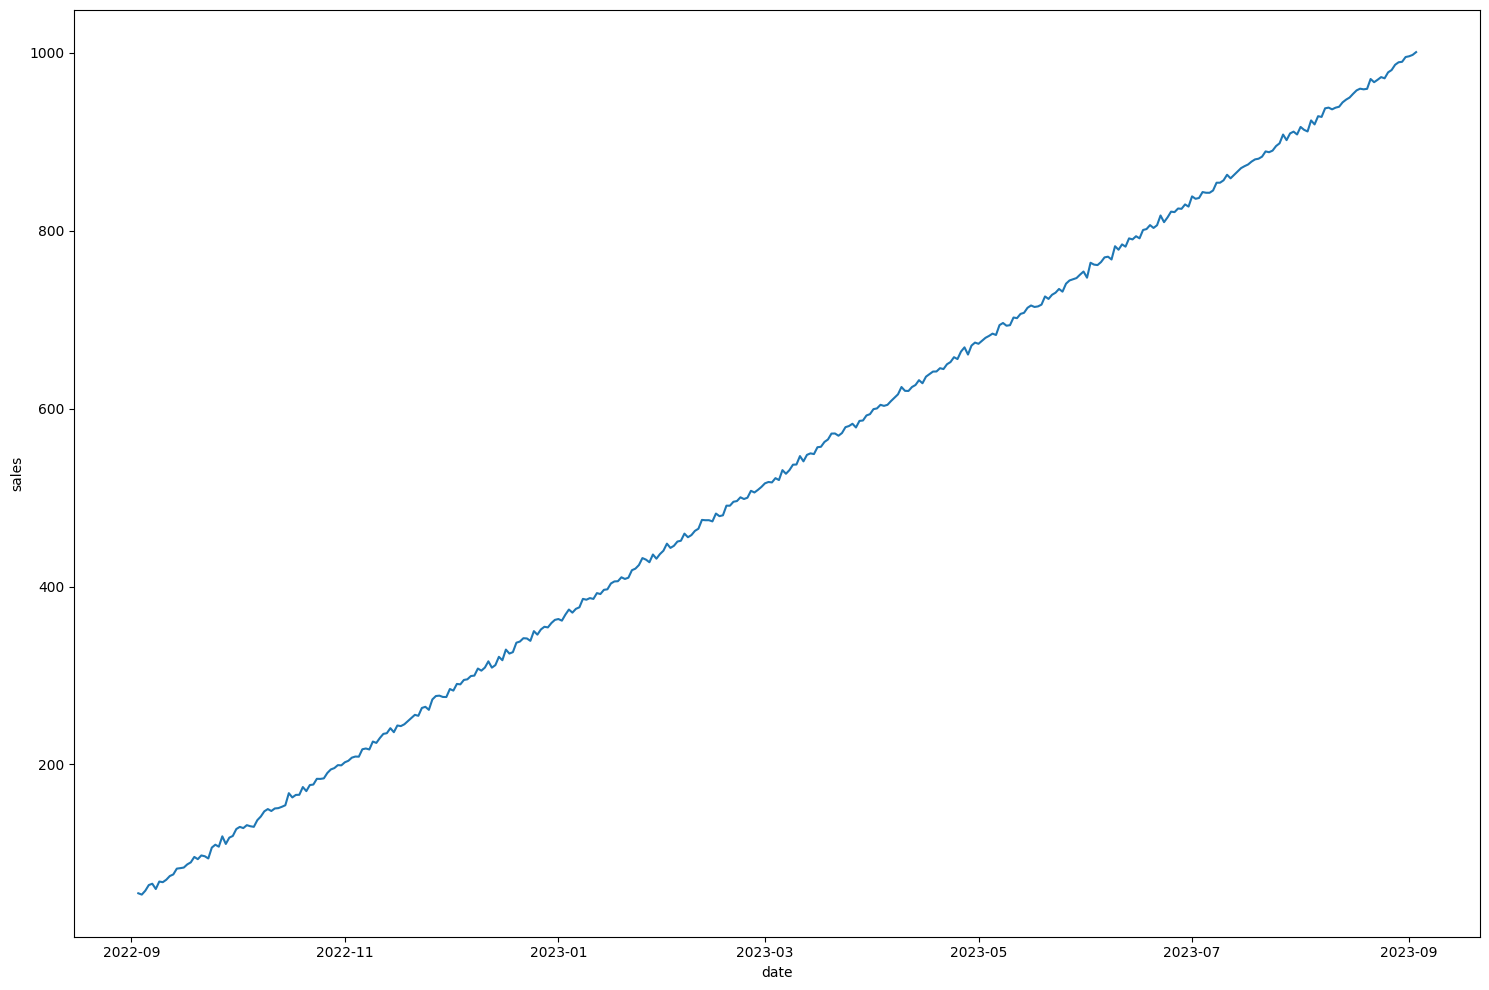

In [7]:
fig, axis = plt.subplots(figsize=(15, 10))

sns.lineplot(data=raw_data, x='date', y='sales')

plt.tight_layout()

plt.show()

## Analysis of a time series

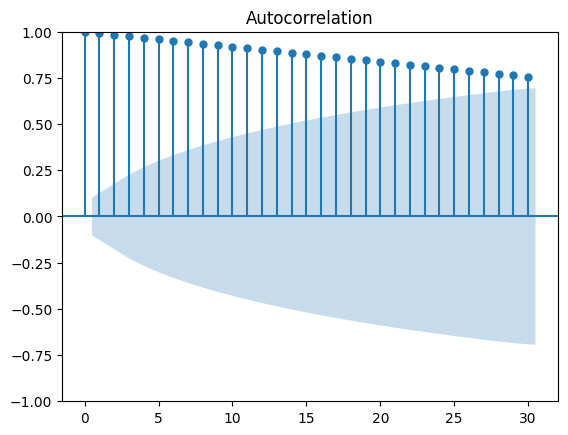

In [8]:
raw_data.set_index('date', inplace=True)
plot_acf(raw_data['sales'], lags=30)  # Check correlations up to 30 days
plt.show()

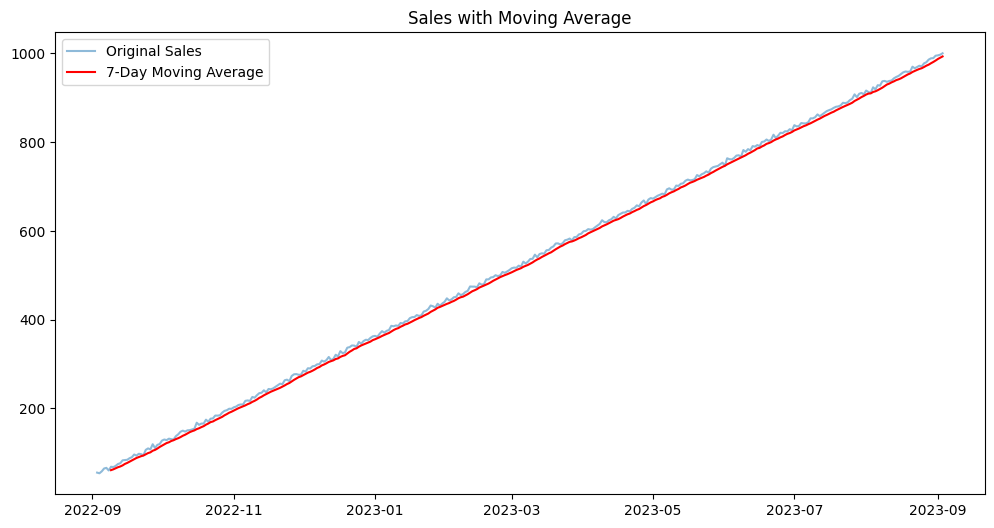

In [9]:
raw_data['sales_ma'] = raw_data['sales'].rolling(window=7).mean()  # 7-day moving average
plt.figure(figsize=(12,6))
plt.plot(raw_data.index, raw_data['sales'], label='Original Sales', alpha=0.5)
plt.plot(raw_data.index, raw_data['sales_ma'], label='7-Day Moving Average', color='red')
plt.legend()
plt.title("Sales with Moving Average")
plt.show()


In [10]:
decomposition = seasonal_decompose(raw_data['sales'], model='additive', period=7)
decomposition

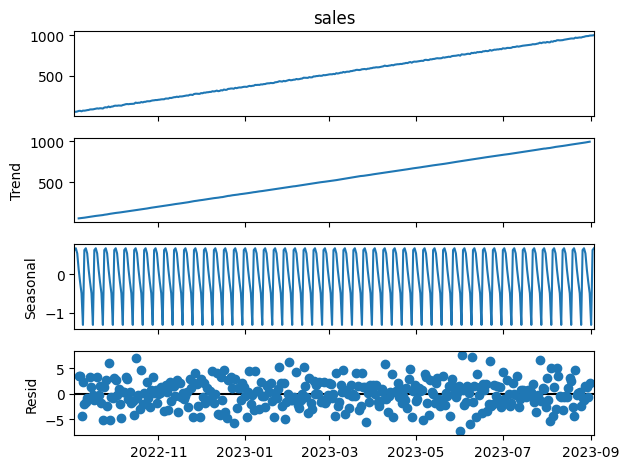

In [11]:
decomposition.plot()
plt.show()

In [12]:
decomposition = seasonal_decompose(raw_data['sales'], model='additive', period=30)
decomposition

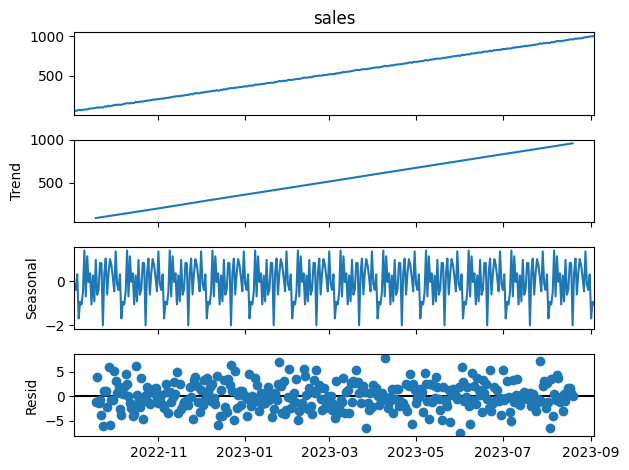

In [13]:
decomposition.plot()
plt.show()

In [14]:
# Decompose using both periods
decomp_7 = seasonal_decompose(raw_data['sales'], model='additive', period=7)
decomp_30 = seasonal_decompose(raw_data['sales'], model='additive', period=30)

# Compute the strength of seasonality
def seasonality_strength(decomposition):
    var_seasonal = np.var(decomposition.seasonal)  # Variance of seasonal component
    var_residual = np.var(decomposition.resid.dropna())  # Variance of residual component
    return var_seasonal / (var_seasonal + var_residual)  # Proportion explained by seasonality

strength_7 = seasonality_strength(decomp_7)
strength_30 = seasonality_strength(decomp_30)

print(f"Seasonality Strength (7-day): {strength_7:.4f}")
print(f"Seasonality Strength (30-day): {strength_30:.4f}")


Seasonality Strength (7-day): 0.0632
Seasonality Strength (30-day): 0.0965


A 30 day period has higher seasonality strength.

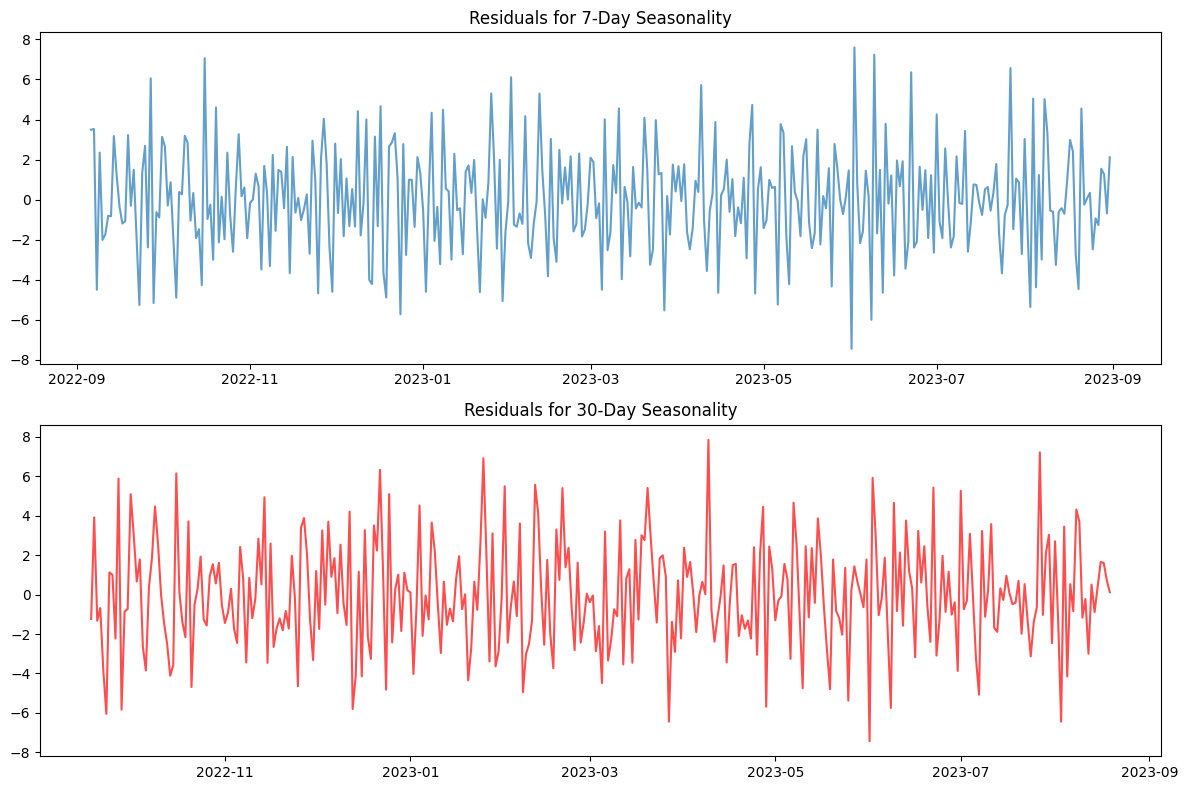

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12,8))
axes[0].plot(decomp_7.resid, label='7-Day Residuals', alpha=0.7)
axes[0].set_title("Residuals for 7-Day Seasonality")
axes[1].plot(decomp_30.resid, label='30-Day Residuals', alpha=0.7, color='red')
axes[1].set_title("Residuals for 30-Day Seasonality")
plt.tight_layout()
plt.show()


A 7 day period has slightly lower residuals

## Test Stationarity

In [16]:
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    if dftest[1] <= 0.05:
        print("Reject the null hypothesis, the time series is stationary")
    else:
        print("Fail to reject the null hypothesis, the time series is non-stationary")
    
    return dfoutput

test_stationarity(raw_data['sales'])

Dickey-Fuller test results:
Fail to reject the null hypothesis, the time series is non-stationary


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

# Train and test the ARIMA Model

In [17]:
# perform differencing to convert the data into stationary data then drop any resulting na values
stationary_data = raw_data['sales'].diff().dropna()
test_stationarity(stationary_data)

Dickey-Fuller test results:
Reject the null hypothesis, the time series is stationary


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Successfully installed numpy-2.2.4
Successfully installed pmdarima-2.0.4 statsmodels-0.14.4

In [18]:
import warnings
warnings.filterwarnings('ignore')
arima_model = pmdarima.auto_arima(raw_data['sales'], seasonal = False, trace = True, m = 30)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.162, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.17 sec


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.074 seconds


In [19]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Wed, 19 Mar 2025   AIC                           1839.552
Time:                        22:57:08   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
forecast = arima_model.predict(10)
forecast

2023-09-04    1002.158148
2023-09-05    1004.831668
2023-09-06    1007.423289
2023-09-07    1010.021630
2023-09-08    1012.619419
2023-09-09    1015.217253
2023-09-10    1017.815084
2023-09-11    1020.412915
2023-09-12    1023.010746
2023-09-13    1025.608577
Freq: D, dtype: float64

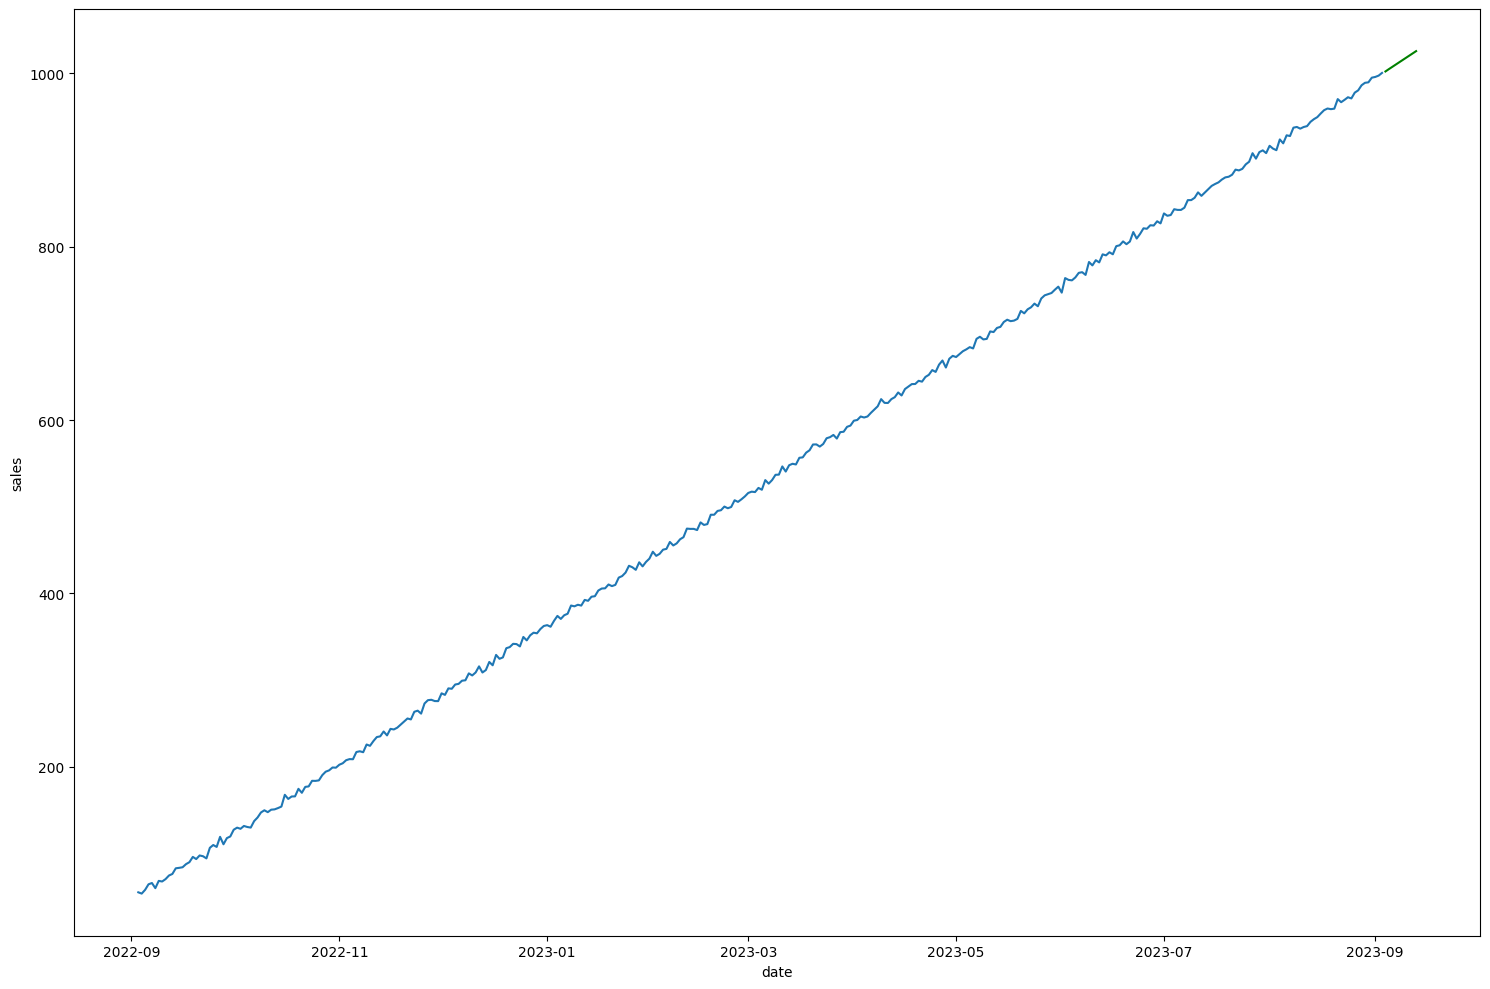

In [21]:
fig, axis = plt.subplots(figsize=(15, 10))

sns.lineplot(data=raw_data['sales'])
sns.lineplot(data=forecast, c='green')

plt.tight_layout()

plt.show()

In [26]:
dump(arima_model, open("../models/arima_seasonal-False_trace-True_m-30.sav", "wb"))